In [2]:
!nvidia-smi

Thu Jun  6 16:43:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-06-06 16:44:46--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2024-06-06 16:44:46--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d4af61c99a9e4e9e4b948e427.dl.dropboxusercontent.com/cd/0/inline/CUUce7v8oXbIHbQrty6mc9xpoJhIEQsCbTyHvgpwd4mE3dtzhyPE0pgxxioKZtLcVp-tS-Of6m68AHabtNPKK6Lx9Qmnjh8P7uenbAZ69S2TA2fSQySG2G64FilQGbyvamooGSYP7zgX9CoV4ymiUTYq/file# [following]
--2024-06-06 16:44:47--  https://uc6d4af61c99a9e4e9e4b948e427.dl.dropboxusercontent.com/cd/0/inline/CUUce7v8oXbIHbQrty6mc9xpoJhIEQsCbTyHvgpwd4mE3dtzhyPE0pgxxioKZtLcVp-tS-Of6m68AHabtNPKK6Lx9Qmnjh8P7uenbAZ69

In [4]:
!unzip -q "/content/archive.zip"

In [5]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [6]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [7]:
# Getting Image paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/surprise/Training_26098669.jpg',
 '/content/train/surprise/Training_14450992.jpg',
 '/content/train/surprise/Training_17221105.jpg',
 '/content/train/surprise/Training_31342045.jpg',
 '/content/train/surprise/Training_30045015.jpg',
 '/content/train/surprise/Training_11999214.jpg',
 '/content/train/surprise/Training_16226895.jpg',
 '/content/train/surprise/Training_16444708.jpg',
 '/content/train/surprise/Training_48715959.jpg',
 '/content/train/surprise/Training_10819158.jpg']

In [8]:
# Getting their respective labels

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise']

In [9]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [10]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
from sklearn.model_selection import train_test_split

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [12]:
# Compute class weights

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.841484, 1: 15.964912, 2: 1.7825661, 3: 1.0, 4: 1.4657718, 5: 1.5315568, 6: 2.2646205}


In [13]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [14]:
# Define IMAGE SIZE and BATCH SIZE
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [15]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [16]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 2.13 s, sys: 54.5 ms, total: 2.18 s
Wall time: 3.09 s
(32, 96, 96, 3)
(32, 7)


neutral


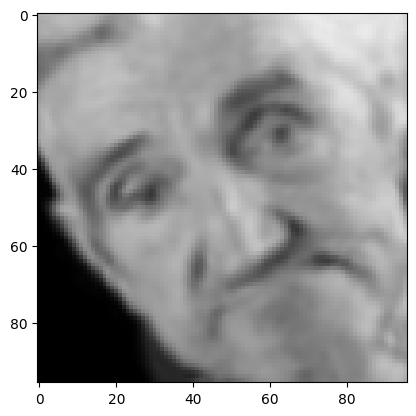

In [17]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [18]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 34.4 ms, sys: 830 µs, total: 35.2 ms
Wall time: 35.2 ms
(32, 96, 96, 3)
(32, 7)


sad


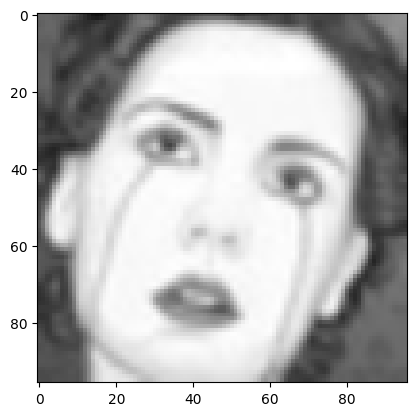

In [19]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [20]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                       

In [21]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [22]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 [==============================] - 152s 131ms/step - loss: 2.8504 - accuracy: 0.3931 - precision: 0.6477 - recall: 0.1795 - val_loss: 1.5202 - val_accuracy: 0.4025 - val_precision: 0.5977 - val_recall: 0.2193
Epoch 2/12
672/672 [==============================] - 82s 122ms/step - loss: 2.4151 - accuracy: 0.4803 - precision: 0.6868 - recall: 0.2779 - val_loss: 1.2672 - val_accuracy: 0.5286 - val_precision: 0.7192 - val_recall: 0.3080
Epoch 3/12
672/672 [==============================] - 87s 130ms/step - loss: 2.2391 - accuracy: 0.5174 - precision: 0.6956 - recall: 0.3253 - val_loss: 1.3219 - val_accuracy: 0.5013 - val_precision: 0.6218 - val_recall: 0.3101
Epoch 4/12
672/672 [==============================] - 87s 130ms/step - loss: 2.1555 - accuracy: 0.5316 - precision: 0.7045 - recall: 0.3472 - val_loss: 1.2834 - val_accuracy: 0.5170 - val_precision: 0.7162 - val_recall: 0.3302
Epoch 5/12
672/672 [==============================] - 82s 122ms/step - loss: 2.0550 - accur

In [23]:
model.layers[0].trainable = False

In [24]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7949824 (30.33 MB)
Trainable params: 181

In [26]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6297 - accuracy: 0.6422 - precision: 0.7579 - recall: 0.5053
Epoch 1: val_loss improved from inf to 1.09305, saving model to best_weights.h5
672/672 [==============================] - 85s 126ms/step - loss: 1.6297 - accuracy: 0.6422 - precision: 0.7579 - recall: 0.5053 - val_loss: 1.0930 - val_accuracy: 0.6035 - val_precision: 0.7009 - val_recall: 0.4979
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6104 - accuracy: 0.6449 - precision: 0.7579 - recall: 0.5114
Epoch 2: val_loss did not improve from 1.09305
672/672 [==============================] - 83s 123ms/step - loss: 1.6104 - accuracy: 0.6449 - precision: 0.7579 - recall: 0.5114 - val_loss: 1.1429 - val_accuracy: 0.5855 - val_precision: 0.6861 - val_recall: 0.4729
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.6419 - accuracy: 0.6383 - precision: 0.7532 - recall: 0.5091
Epoch 3: val_loss improved from 1.09305 to 1.

In [27]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [28]:
model.load_weights("best_weights.h5")

In [29]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [30]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


surprise


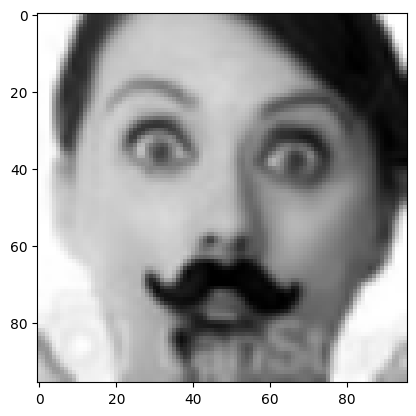

In [31]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [32]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 11s 28ms/step - loss: 1.0256 - accuracy: 0.6230 - precision: 0.7155 - recall: 0.5202
 Testing Acc :  0.6230147480964661
 Testing Precision  0.7154627442359924
 Testing Recall  0.5202006101608276


In [33]:
# Save Model
model.save("FacialExpressionModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# Save Label Encoder
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [35]:
save_object(Le, "LabelEncoder")